In [ ]:
pip install fastFM

In [ ]:
import os
import json
import gzip
import pandas as pd
from urllib.request import urlopen

import random
import numpy as np
from collections import defaultdict
import seaborn as sns
import sklearn
from sklearn import linear_model
import dateutil
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy
from fastFM import als
from sklearn.metrics import mean_squared_error
import math
from gensim.models import Word2Vec
from nltk.stem.porter import *
from sklearn import linear_model
from sklearn.manifold import TSNE
import string

In [ ]:
!wget https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/categoryFilesSmall/Industrial_and_Scientific_5.json.gz

--2023-12-04 01:32:09--  https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/categoryFilesSmall/Industrial_and_Scientific_5.json.gz
Resolving datarepo.eng.ucsd.edu (datarepo.eng.ucsd.edu)... 132.239.8.30
Connecting to datarepo.eng.ucsd.edu (datarepo.eng.ucsd.edu)|132.239.8.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10994038 (10M) [application/x-gzip]
Saving to: ‘Industrial_and_Scientific_5.json.gz.4’

Industrial_and_Scie 100%[===================>]  10.48M  27.3MB/s    in 0.4s    

2023-12-04 01:32:10 (27.3 MB/s) - ‘Industrial_and_Scientific_5.json.gz.4’ saved [10994038/10994038]



In [ ]:
### load the meta data

data = []
with gzip.open('Industrial_and_Scientific_5.json.gz') as f:
    for l in f:
        data.append(json.loads(l.strip()))

# total length of list, this number equals total number of products
print(len(data))

# first row of the list
print(data[0])

77071
{'overall': 5.0, 'verified': True, 'reviewTime': '11 27, 2017', 'reviewerID': 'A1JB7HFWHRYHT7', 'asin': 'B0000223SI', 'style': {'Size:': ' 1-(Pack)'}, 'reviewerName': 'Alex W.', 'reviewText': "This worked really well for what I used it for. So for my purposes it is getting full marks. This is an all around great, durable, and afforable sandpaper.\n\nPros:\n-Grit cuts really fast and evenly. No random deep scratches like I have seen in some cheaper paper\n-Didn't even have a hint of clogging up.\n-The adhesive is just what I needed. No permanent, but wasn't going anywhere.\n\nCons:\n-None", 'summary': "Couldn't have been happier with it's performance", 'unixReviewTime': 1511740800}


In [ ]:
# convert list into pandas dataframe

df = pd.DataFrame.from_dict(data)

print(len(df))

77071


In [ ]:
# Fill None values with empty strings
df3 = df.fillna('')

# # Filter rows where reviewText contains 'getTime'
# df4 = df3[df3.reviewText.str.contains('getTime')] # unformatted rows

# # Filter out rows where reviewText contains 'getTime'
# df5 = df3[~df3.reviewText.str.contains('getTime')] # formatted rows

# print(len(df4))
# print(len(df5))

In [ ]:
# EXPLORATORY ANALYSIS
print(data[0])
print('entries: ' + str(len(data)))

# set of all users
allUsers = set()

# set of all items
allItems = set()

# set of all review texts
reviews = []

reviewData = []
for d in data:
  if 'reviewText' in d:
    reviewData.append(d) # getting rid of reviews without text
    allUsers.add(d['reviewerID'])
    allItems.add(d['asin'])
    reviews.append(d['reviewText'])
print('users: ' + str(len(allUsers)))
print('items: ' + str(len(allItems)))
print('cleaned data: ' + str(len(reviewData)))

{'overall': 5.0, 'verified': True, 'reviewTime': '11 27, 2017', 'reviewerID': 'A1JB7HFWHRYHT7', 'asin': 'B0000223SI', 'style': {'Size:': ' 1-(Pack)'}, 'reviewerName': 'Alex W.', 'reviewText': "This worked really well for what I used it for. So for my purposes it is getting full marks. This is an all around great, durable, and afforable sandpaper.\n\nPros:\n-Grit cuts really fast and evenly. No random deep scratches like I have seen in some cheaper paper\n-Didn't even have a hint of clogging up.\n-The adhesive is just what I needed. No permanent, but wasn't going anywhere.\n\nCons:\n-None", 'summary': "Couldn't have been happier with it's performance", 'unixReviewTime': 1511740800}
entries: 77071
users: 11041
items: 5334
cleaned data: 77060


<Axes: xlabel='overall', ylabel='Count'>

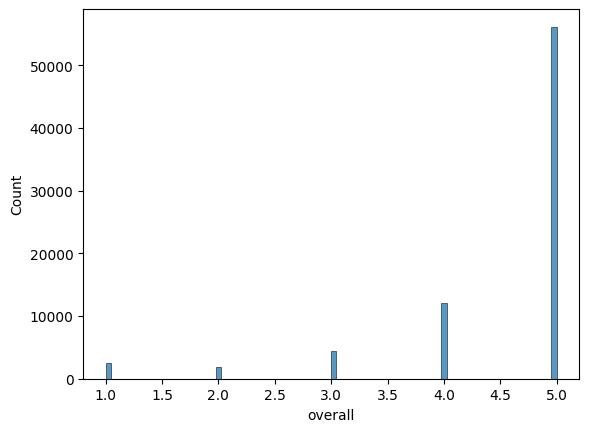

In [ ]:
# Convert cleaned data to a DataFrame
reviewData_df = pd.DataFrame(reviewData)

# Create a histogram of the 'quality' column
sns.histplot(reviewData_df['overall'])

In [ ]:
reviewData_df.head()

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,5.0,True,"11 27, 2017",A1JB7HFWHRYHT7,B0000223SI,{'Size:': ' 1-(Pack)'},Alex W.,This worked really well for what I used it for...,Couldn't have been happier with it's performance,1511740800,NaN,NaN
1,5.0,True,"11 4, 2017",A2FCLJG5GV8SD6,B0000223SI,{'Size:': ' 1-(Pack)'},Randall Harris,Fast cutting and good adheasive.,Good paper.,1509753600,NaN,NaN
2,5.0,False,"10 27, 2017",A3IT9B33NWYQSL,B0000223SI,{'Size:': ' 1-(Pack)'},A. C.,Worked great for my lapping bench. I would li...,Handy!,1509062400,NaN,NaN
3,4.0,True,"01 13, 2018",AUL5LCV4TT73P,B0000223SK,{'Size:': ' 1-Pack'},TnT,As advertised,As advertised,1515801600,NaN,NaN
4,5.0,True,"10 7, 2017",A1V3I3L5JKO7TM,B0000223SK,{'Size:': ' 1-Pack'},John Jones,seems like a pretty good value as opposed to b...,seems like a pretty good value as opposed to b...,1507334400,NaN,NaN


In [ ]:
# Extract the review dates
review_dates = pd.to_datetime(reviewData_df['reviewTime'])

# Find the start and end of the time period
start_date = review_dates.min()
end_date = review_dates.max()

print('The dataset covers the time period from ' + start_date.strftime('%B %d, %Y') + ' to ' + end_date.strftime('%B %d, %Y'))

The dataset covers the time period from April 27, 2003 to September 28, 2018


Sliding window

In [ ]:
ratingsTime = []

for d in reviewData:
    t = dateutil.parser.parse(d['reviewTime'])
    ratingsTime.append((t,d['overall'], d['unixReviewTime']))
    if len(ratingsTime) >= 50000:
        break

In [ ]:
# sort observations by time
ratingsTime.sort()
len(ratingsTime)

50000

In [ ]:
# Keep track of a window (wSize) of ratings and timestamps (the raw time is just for printing the plot)
wSize = 1000
x = [r[0] for r in ratingsTime] # as raw times
y = [r[1] for r in ratingsTime] # ratings
xu = [r[2] for r in ratingsTime] # as unix times

In [ ]:
# Use a dynamic-programming approach to build the sliding window
xSum = sum(xu[:wSize])
ySum = sum(y[:wSize])
sliding = []

In [ ]:
for i in range(wSize,len(x)-1):
    xSum += xu[i] - xu[i-wSize]
    ySum += y[i] - y[i-wSize]
    sliding.append((xSum*1.0/wSize,ySum*1.0/wSize))

In [ ]:
#X and Y coordinates for plotting
X = [a[0] for a in sliding]
Y = [a[1] for a in sliding]

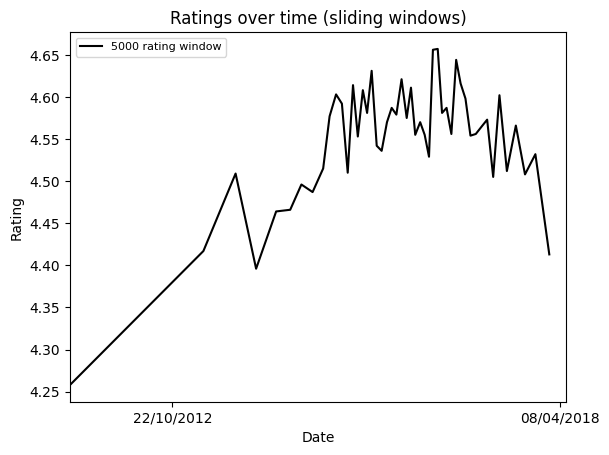

In [ ]:
plt.plot(X[::1000],Y[::1000], label="5000 rating window", color='k')
plt.xticks([X[600], X[-350]], [x[wSize+600].strftime("%d/%m/%Y"), x[-350].strftime("%d/%m/%Y")])
plt.xlim(X[0], X[-1])
plt.ylabel("Rating")
plt.xlabel("Date")
plt.legend(loc="best",fontsize=8)
plt.title("Ratings over time (sliding windows)")
plt.show()

Word Cloud

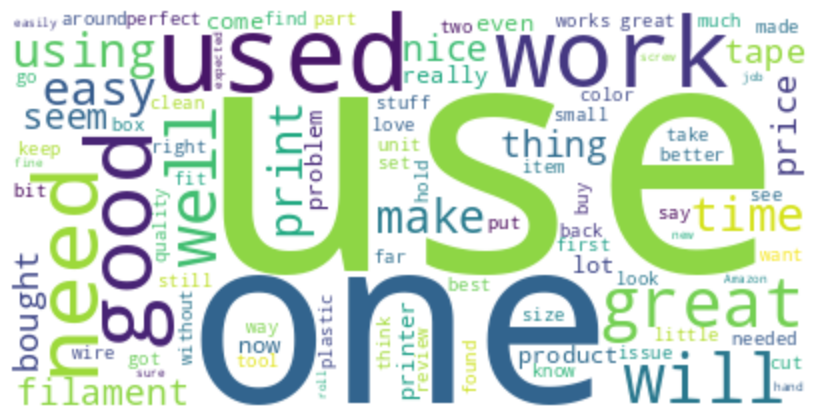

In [ ]:
from wordcloud import WordCloud, STOPWORDS

# Define the text for the word cloud
text = ' '.join([d['reviewText'] for d in reviewData])

# Generate the word cloud
wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white').generate(text)

# Plot the word cloud
plt.figure(figsize=(8, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [ ]:
# Define the size of each set
train_size = 0.5 # 50% of the data for training
test_size = 0.5 # 50% of the data for testing

# Calculate the indices for each set
train_end = int(len(reviewData) * train_size)

# Split the data
dataTrain = reviewData[:train_end]
dataTest = reviewData[train_end:]

# Print the size of each set
print(len(dataTrain), len(dataTest))

38530 38530


In [ ]:
def feature(d):
    feat = [1] # Constant feature
    feat.append(len(d['reviewText'])) # Length of review
    return feat

In [ ]:
X = [feature(d) for d in dataTrain]
y = [d['overall'] for d in dataTrain]

In [ ]:
#Fit the model and extract the coefficients

model = sklearn.linear_model.LinearRegression(fit_intercept=False)
model.fit(X, y)
theta = model.coef_
theta

array([ 4.59115122e+00, -1.75086413e-04])

In [ ]:
Xtest = [feature(d) for d in dataTest]
y_pred = model.predict(Xtest)

In [ ]:
sse = sum([x**2 for x in (y - y_pred)])
mse = sse / len(y)
mse

0.8412538997076608

Predicting mean baseline

In [ ]:
ratingMean = sum(d['overall'] for d in dataTrain) / len(dataTrain)

In [ ]:
y_pred = [ratingMean for d in dataTest]
y = [d['overall'] for d in dataTest]

In [ ]:
# Calculate the MSE
mse = mean_squared_error(y, y_pred)

print(mse)

0.9736244737416969


FISM

In [ ]:
userIDs = {}
itemIDs = {}
interactions = []
interactionsPerUser = defaultdict(list)
for d in reviewData:
    u = d['reviewerID']
    i = d['asin']
    t = d['reviewTime']
    r = d['overall']
    dt = dateutil.parser.parse(t)
    t = int(dt.timestamp())
    if not u in userIDs: userIDs[u] = len(userIDs)
    if not i in itemIDs: itemIDs[i] = len(itemIDs)
    interactions.append((t,u,i,r))
    interactionsPerUser[u].append((t,i,r))

In [ ]:
# Interaction with timestamp
interactions[0]

(1511740800, 'A1JB7HFWHRYHT7', 'B0000223SI', 5.0)

In [ ]:
len(interactions)

77060

In [ ]:
# Sort interactions by time (including interaction sequences for each user). Useful when building data structures that include adjacent pairs of interactions (but consider whether this is desirable if making train/test splits!).
interactions = [x for x in interactions if x[3] is not None]
interactions.sort()

In [ ]:
nItems = len(itemIDs)
nUsers = len(userIDs)

In [ ]:
fismInter = random.sample(interactions,75000)

In [ ]:
#Factorization machine design matrix. Note that we have two sets of features (the user history, and the target item). Both are of dimension nItems.

X = scipy.sparse.lil_matrix((len(fismInter), 2*nItems))

In [ ]:
itemsPerUser = defaultdict(set)
for _,u,i,_ in interactions:
    itemsPerUser[u].add(i)

In [ ]:
for n in range(len(fismInter)):
    _,u,i,r = fismInter[n]
    item = itemIDs[i]
    history = itemsPerUser[u]
    for j in history:
        if i == j: continue # Exclude the target item from the history
        X[n,itemIDs[j]] = 1.0 / (len(history) - 1) # One-hot encoding, normalized by history length
    X[n,nItems + item] = 1

In [ ]:
y = np.array([r for _,_,_,r in fismInter])

In [ ]:
#Fairly slow and memory-hungry (every row contains a copy of a user's history). Could possibly be implemented faster in Tensorflow.

fm = als.FMRegression(n_iter=1000, init_stdev=0.1, rank=5, l2_reg_w=0.1, l2_reg_V=0.5)

In [ ]:
X_train,y_train = X[:67500],y[:67500]
X_test,y_test = X[67500:],y[67500:]

In [ ]:
fm.fit(X_train, y_train)

FMRegression(l2_reg_V=0.5, n_iter=1000, rank=5)

In [ ]:
y_pred = fm.predict(X_test)

In [ ]:
def MSE(predictions, labels):
   differences = [(x-y)**2 for x,y in zip(predictions,labels)]
   return sum(differences) / len(differences)

In [ ]:
MSE(y_pred, y_test)

1.2105461543932536

Autoregression

In [ ]:
events = {}

for d in dataTrain:
  itemID = d['asin']
  timeString = d['reviewTime']
  # Convert the review date to a Unix timestamp
  timeUnix = d['unixReviewTime']
  # Store the  ID and the Unix timestamp in the events dictionary
  events[itemID] = [timeUnix, timeString]

In [ ]:
# Find the earliest event (so that we can sort events from the first to the last hour)
earliest = None
for event in events:
    if earliest == None or events[event][0] < earliest[0]:
        earliest = events[event]

In [ ]:
earliestTime = earliest[0]

In [ ]:
# Count events by hour
hourly = defaultdict(int)

for event in events:
    t = events[event][0]
    hour = int(t - earliestTime) // (60*60)
    hourly[hour] += 1

In [ ]:
def feature(hour):
    previousHours = []
    # Features for last 5 hours, one day ago, one week ago, and one year ago
    for i in [1,2,3,4,5,24,24*7,24*7*365]:
        previousHour = hour - i
        previousHourExists = previousHour in hourly
        if previousHourExists:
            previousHours += [hourly[previousHour]]
        else:
            previousHours += [0]
    return previousHours

In [ ]:
X = [feature(x) for x in hourly]
y = [hourly[x] for x in hourly]

In [ ]:
model = sklearn.linear_model.LinearRegression(fit_intercept=False)
model.fit(X, y)
theta = model.coef_

In [ ]:
theta
# The observation from a year ago is the most predictive, followed by the one from the previous week

array([ 0.00000000e+00, -1.11022302e-16,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  4.53412486e-01,  4.78147702e-01,  2.89591039e-01])

In [ ]:
y_pred = model.predict(X)

In [ ]:
MSE(y, y_pred)

2.5337607381765723

Similarity model adapted to time-weight collaborative filtering

In [ ]:
def Jaccard(s1, s2):
    numer = len(s1.intersection(s2))
    denom = len(s1.union(s2))
    if denom == 0:
        return 0
    return numer / denom

def CosineSet(s1, s2):
    # Not a proper implementation, operates on sets so correct for interactions only
    numer = len(s1.intersection(s2))
    denom = math.sqrt(len(s1)) * math.sqrt(len(s2))
    if denom == 0:
        return 0
    return numer / denom

In [ ]:
usersPerItem = defaultdict(set) # Maps an item to the users who rated it
itemsPerUser = defaultdict(set) # Maps a user to the items that they rated
itemNames = {}
ratingDict = {} # To retrieve a rating for a specific user/item pair

for d in dataTrain:
    user,item = d['reviewerID'], d['asin']
    usersPerItem[item].add(user)
    itemsPerUser[user].add(item)
    ratingDict[(user,item)] = int(d['overall'])

In [ ]:
userAverages = {}
itemAverages = {}

for u in itemsPerUser:
    rs = [ratingDict[(u,i)] for i in itemsPerUser[u]]
    userAverages[u] = sum(rs) / len(rs)

for i in usersPerItem:
    rs = [ratingDict[(u,i)] for u in usersPerItem[i]]
    itemAverages[i] = sum(rs) / len(rs)

In [ ]:
#Use our similarity functions to estimate ratings. Start by building a few utility data structures.

reviewsPerUser = defaultdict(list)
reviewsPerItem = defaultdict(list)

In [ ]:
for d in dataTrain:
    user,item = d['reviewerID'], d['asin']
    reviewsPerUser[user].append(d)
    reviewsPerItem[item].append(d)

In [ ]:
ratingMean = sum(d['overall'] for d in dataTrain) / len(dataTrain)

In [ ]:
ratingMean

4.55403581624708

In [ ]:
#Rating prediction heuristic (several alternatives from Chapter 4 could be used)

def predictRating(user,item,timestamp):
    ratings = []
    similarities = []
    timesList = []
    for d in reviewsPerUser[user]:
        i2 = d['asin']
        if i2 == item: continue
        ratings.append(d['overall'] - itemAverages[i2])
        # Calculate the Jaccard similarity with the time-based weighting factor
        similarities.append(CosineSet(usersPerItem[item],usersPerItem[i2]))
        date = d['unixReviewTime']
        timesList.append(math.exp(-5*timestamp))
    if (sum(similarities) > 0):
        weightedRatings = [(x*y*z) for x,y,z in zip(ratings,similarities,timesList)]
        temp = [(y*z) for y,z in zip(similarities,timesList)]
        return itemAverages[item] + sum(weightedRatings) / (sum(temp)+1)
        #return itemAverages[item] + sum(weightedRatings) / sum(similarities)*sum(timesList)
    else:
        if item in itemAverages:
            return itemAverages[item] #returning item avg if seen before
        # User hasn't rated any similar items
        return ratingMean

In [ ]:
def MSE(predictions, labels):
    differences = [(x-y)**2 for x,y in zip(predictions,labels)]
    return sum(differences) / len(differences)

In [ ]:
#Compared to a trivial predictor which always predicts the mean

alwaysPredictMean = [ratingMean for d in dataTest]

In [ ]:
#Get predictions for all instances (fairly slow!)

simPredictions = [predictRating(d['reviewerID'], d['asin'], d['unixReviewTime']) for d in dataTest]

In [ ]:
labels = [d['overall'] for d in dataTest]

In [ ]:
MSE(alwaysPredictMean, labels)

0.9736244737425852

In [ ]:
#MSE(simPredictions, labels)
print(f"The Mean Squared Error of the time weight collaborative filtering model is {MSE(simPredictions, labels)}")

The Mean Squared Error of the time weight collaborative filtering model is 0.986093275481058


In [ ]:
# Generate random ratings
random_ratings = np.random.uniform(low=1, high=5, size=(len(reviewData),))

# Calculate the MSE of the random ratings
mse = mean_squared_error(random_ratings, [d['overall'] for d in reviewData])

print(f"The Mean Squared Error of the dummy random baseline model is {mse}")

The Mean Squared Error of the dummy random baseline model is 4.562658536794055


Word

In [ ]:
wordCount = defaultdict(int)
for d in reviewData:
    for w in d['reviewText'].split():
        wordCount[w] += 1

len(wordCount) # unique words

116265

In [ ]:
# Ignore capitalization and remove punctuation

wordCount = defaultdict(int)
punctuation = set(string.punctuation)
for d in reviewData:
    r = ''.join([c for c in d['reviewText'].lower() if not c in punctuation])
    for w in r.split():
        wordCount[w] += 1

len(wordCount)

51563

In [ ]:
#With stemming

wordCount = defaultdict(int)
punctuation = set(string.punctuation)
stemmer = PorterStemmer()
for d in reviewData:
  r = ''.join([c for c in d['reviewText'].lower() if not c in punctuation])
  for w in r.split():
    w = stemmer.stem(w)
    wordCount[w] += 1

len(wordCount)

39015

In [ ]:
#Just build our feature vector by taking the most popular words (lowercase, punctuation removed, but no stemming)

wordCount = defaultdict(int)
punctuation = set(string.punctuation)
for d in reviewData:
  r = ''.join([c for c in d['reviewText'].lower() if not c in punctuation])
  for w in r.split():
    wordCount[w] += 1

counts = [(wordCount[w], w) for w in wordCount]
counts.sort()
counts.reverse()

In [ ]:
words = [x[1] for x in counts[:1000]]

Jaccard

In [ ]:
reviewsPerUser = defaultdict(list)
reviewsPerItem = defaultdict(list)

In [ ]:
for d in dataTrain:
    user,item = d['reviewerID'], d['asin']
    reviewsPerUser[user].append(d)
    reviewsPerItem[item].append(d)

In [ ]:
ratingMean = sum(d['overall'] for d in dataTrain) / len(dataTrain)

In [ ]:
def predictRating(user,item):
    ratings = []
    similarities = []
    for d in reviewsPerUser[user]:
        i2 = d['asin']
        if i2 == item: continue
        ratings.append(d['overall'] - itemAverages[i2])
        similarities.append(Jaccard(usersPerItem[item],usersPerItem[i2]))
    if (sum(similarities) > 0):
        weightedRatings = [(x*y) for x,y in zip(ratings,similarities)]
        return itemAverages[item] + sum(weightedRatings) / sum(similarities)
    else:
        # User hasn't rated any similar items
        return ratingMean

In [ ]:
simPredictions = [predictRating(d['reviewerID'], d['asin']) for d in dataTest]

In [ ]:
labels = [d['overall'] for d in dataTest]

In [ ]:
MSE(simPredictions, labels)

0.9759299812708743